# Regrid Fe geothermal vent source from x1 dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from datetime import date, datetime, timezone

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import esmlab
import esmlab_regrid

import pop_tools
import util

id_string = 'Fe_vent_flux_forcing.ipynb from github.com/marbl-ecosys/forcing-Fe-sedflux'

## Setup the problem
- specify the input file
- specify the source and destination grids

In [3]:
feventflux_file = f'{util.inputdata}/ocn/pop/gx1v7/forcing/feventflux_gx1v6_5gmol_cesm1_97_2017.nc'
src_grid = 'POP_gx1v7'
# dst_grid = 'POP_tx0.1v3'
dst_grid = 'MOM_tx0.66v1'

## Read the input file

Rename the coords/dims to be standard and attach coordinates and grid variables.

In [4]:
ds_src = xr.open_dataset(feventflux_file).rename(
    x='nlon',
    y='nlat',
    z='z_t',
)
ds_src = xr.merge((ds_src, pop_tools.get_grid(src_grid)[['TAREA', 'z_t', 'KMT']]))
ds_src.info()

/glade/work/mlevy/miniconda3/envs/forcing-Fe-sedflux/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


xarray.Dataset {
dimensions:
	z_t = 60 ;
	nlat = 384 ;
	nlon = 320 ;

variables:
	float64 z_t(z_t) ;
	float32 FESEDFLUXIN(z_t, nlat, nlon) ;
	float64 TAREA(nlat, nlon) ;
		TAREA:units = cm^2 ;
		TAREA:long_name = area of T cells ;
		TAREA:coordinates = TLONG TLAT ;
	int32 KMT(nlat, nlon) ;
		KMT:long_name = k Index of Deepest Grid Cell on T Grid ;
		KMT:coordinates = TLONG TLAT ;

// global attributes:
}

## Setup regridder

In [5]:
method = 'conservative'
weight_file = util.file_name_weight(src_grid, dst_grid, method)
assert os.path.exists(weight_file)
weight_file

'/glade/work/mlevy/esmlab-regrid/weights/POP_gx1v7_to_MOM_tx0.66v1_conservative.nc'

In [6]:
regrid_operator = esmlab_regrid.regridder(
    name_grid_src=src_grid, 
    name_grid_dst=dst_grid, 
    method=method, 
    overwrite_existing=False
)
regrid_operator

## Perform regridding 

In [7]:
pop_grid = pop_tools.get_grid(src_grid)
mom_grid = util.get_MOM_grid("MOM_tx0.66v1")
dst_z_t, dst_z_w = util.get_WOA_zt_and_zw()

In [8]:
da_dst_lateral = regrid_operator(
        ds_src.FESEDFLUXIN,
        renormalize=True, 
        apply_mask=True
    )

try:
    da_dst = util.remap_z_t(da_dst_lateral, src_grid, dst_grid).fillna(0.)
except:
    da_dst = util.reintegrate_z_t_to_MOM(da_dst_lateral, src_grid).fillna(0.)
da_dst

<xarray.DataArray (z_t: 103, nlat: 458, nlon: 540)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * z_t      (z_t) float64 250.0 750.0 1.25e+03 ... 5.45e+05 5.625e+05 5.875e+05
Dimensions without coordinates: nlat, nlon
Attributes:
    regrid_method:  conservative
    history:        \n2021-11-09 20:14:33.625076 esmlab.regrid <regrid>

## Construct output dataset and write to file

In [9]:
try:
    ds_dst = pop_tools.get_grid(dst_grid)[['TLONG', 'TLAT', 'TAREA', 'KMT', 'z_t']]
except:
    ds_dst = util.get_MOM_grid(dst_grid)
ds_dst['FESEDFLUXIN'] = da_dst #.astype(np.single)
ds_dst.FESEDFLUXIN.encoding = {'_FillValue': None, 'dtype': np.single}
ds_dst.FESEDFLUXIN.attrs['units'] = 'micromol/m^2/d'
ds_dst.FESEDFLUXIN.attrs['long_name'] = 'Fe geothermal vent flux'

# Rename variables, unit conversion
ds_dst['TAREA'] = ds_dst['TAREA']/1e4
ds_dst['TAREA'].attrs['units'] = 'm^2'
ds_dst['TAREA'].encoding['_FillValue'] = None
ds_dst['z_t'] = ds_dst['z_t']/100.
ds_dst['z_t'].attrs['units'] = 'm'
ds_dst['z_t'].encoding['_FillValue'] = None
ds_dst = ds_dst.rename({'z_t': 'DEPTH', 'nlat': 'NLAT', 'nlon': 'NLON'})
ds_dst['DEPTH_EDGES'] = xr.DataArray(util.get_WOA_zt_and_zw()[1]/100, dims='DEPTH_EDGES')
ds_dst['DEPTH_EDGES'].attrs['units'] = 'm'
ds_dst['DEPTH_EDGES'].encoding['_FillValue'] = None
ds_dst['DEPTH'].attrs['edges'] = 'DEPTH_EDGES'

assert ~np.isnan(ds_dst.FESEDFLUXIN.values).any()

# Apply mask where KMT = 0
# ds_dst['FESEDFLUXIN'] = ds_dst['FESEDFLUXIN'].where(ds_dst.KMT > 0)
    
datestamp = datetime.now(timezone.utc).strftime("%Y-%m-%d")
ds_dst.attrs['history'] = f'created by {id_string} on {datestamp}'

datestamp = date.today().strftime("%y%m%d")
file_out = f'{util.dirout}/feventflux_5gmol_{dst_grid[4:]}.c{datestamp}.nc'

ds_dst.to_netcdf(file_out)
util.ncks_fl_fmt64bit(file_out)

print(f'wrote: {file_out}')

ds_dst.info()

wrote: /glade/work/mlevy/cesm_inputdata/feventflux_5gmol_tx0.66v1.c211109.nc
xarray.Dataset {
dimensions:
	NLAT = 458 ;
	NLON = 540 ;
	DEPTH = 103 ;
	DEPTH_EDGES = 104 ;

variables:
	float64 TAREA(NLAT, NLON) ;
		TAREA:long_name = Surface area of tracer (T) cells ;
		TAREA:units = m^2 ;
		TAREA:cell_methods = area:sum yh:sum xh:sum time: point ;
	float64 TLAT(NLAT, NLON) ;
		TLAT:long_name = Latitude of tracer (T) points ;
		TLAT:units = degrees_north ;
		TLAT:cell_methods = time: point ;
	float64 TLONG(NLAT, NLON) ;
		TLONG:long_name = Longitude of tracer (T) points ;
		TLONG:units = degrees_east ;
		TLONG:cell_methods = time: point ;
	float64 DEPTH(DEPTH) ;
		DEPTH:units = m ;
		DEPTH:edges = DEPTH_EDGES ;
	int32 KMT(NLAT, NLON) ;
	float64 FESEDFLUXIN(DEPTH, NLAT, NLON) ;
		FESEDFLUXIN:regrid_method = conservative ;
		FESEDFLUXIN:history = 
2021-11-09 20:14:33.625076 esmlab.regrid <regrid>  ;
		FESEDFLUXIN:units = micromol/m^2/d ;
		FESEDFLUXIN:long_name = Fe geothermal vent flux ;
	

## Compare output with input

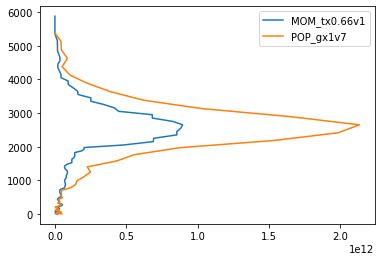

In [10]:
# with xr.set_options(keep_attrs=True):
#     (ds_dst.FESEDFLUXIN * ds_dst.TAREA).sum(['NLAT', 'NLON']).plot(label=dst_grid)
#     (ds_src.FESEDFLUXIN * ds_src.TAREA).sum(['nlat', 'nlon']).plot(label=src_grid)
# plt.legend();

plt.plot((ds_dst.FESEDFLUXIN * ds_dst.TAREA).sum(['NLAT', 'NLON']), ds_dst.DEPTH, label=dst_grid)
plt.plot((ds_src.FESEDFLUXIN * ds_src.TAREA/1e4).sum(['nlat', 'nlon']), ds_src.z_t/100, label=src_grid)
plt.legend();

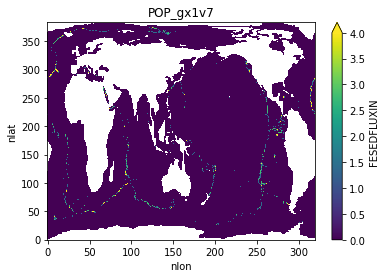

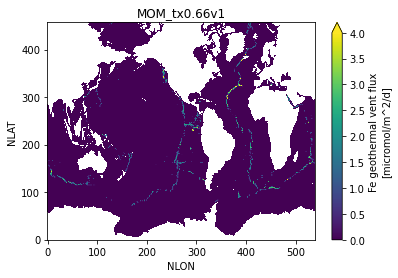

In [11]:
plt.figure()
ds_src.FESEDFLUXIN.sum('z_t').where(ds_src.KMT > 0).plot(vmin=0, vmax=4)
plt.title(src_grid)

plt.figure()
ds_dst.FESEDFLUXIN.sum('DEPTH').where(ds_dst.KMT > 0).plot(vmin=0, vmax=4)
plt.title(dst_grid);

In [12]:
mol_per_µmol = 1e-6
mol_per_Gmol = 1e9
cm2_per_m2 = 1e4 
d_per_yr = 365.0

def report_global_integral(ds, xdims=('nlat', 'nlon'), zdim='z_t', area_scale=1):
    total = esmlab.statistics.weighted_sum(
        ds.FESEDFLUXIN, 
        weights=ds.TAREA*area_scale, 
        dim=xdims).sum(zdim) * mol_per_µmol / mol_per_Gmol * d_per_yr
    print(f'Global integral = {total.values:0.4f} Gmol Fe/yr')

    
print(f'{src_grid}: ', end='')
report_global_integral(ds_src, area_scale=1e-4)

print(f'{dst_grid}: ', end='')
report_global_integral(ds_dst, xdims=('NLAT', 'NLON'), zdim='DEPTH')    

POP_gx1v7: Global integral = 5.0480 Gmol Fe/yr
MOM_tx0.66v1: Global integral = 4.9898 Gmol Fe/yr


In [13]:
ds_src.TAREA.sum()

<xarray.DataArray 'TAREA' ()>
array(5.04921015e+18)

In [14]:
ds_dst.TAREA.sum()

<xarray.DataArray 'TAREA' ()>
array(5.05637869e+14)